# multiple comparisons correction comparison

a confusing title: there is different ways in which to make multiple comparisons, namely  looking at the chance number
of significant time bins for individual context_pair probe combinations, or pooling across context_pairs, probes, or both

these alternatives are implemented in src.metrics.significance._significance where the parameter
multiple_comparisons_axis can be None (for no correction, the old way) or a list of ints specifiying the dimensions
of the array over which pool and count multiple comparisons.

on the pipeline these  different sets of dimensions are coded as keywords:
multiple_corrections = {'none':None,
                        'full': [1,2,3],
                        'time': [3],
                        'probe': [2,3],
                        'context_pair': [1,3]}



Furthermore, there is the question on howe to deals with significance for the mean values, There is two appraoches so far
* Take the mean of the significance and if > 0 then the mean value is significant (old) key: "mean"
* set the non significant values to 0 and calculate the mean (new) key: "zeros"
* Do something with the p values (mean?) and use to calculate new significance (not implemented)

In [27]:
from configparser import ConfigParser
from pathlib import Path
from joblib import load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from src.visualization.fancy_plots import unit_line
import seaborn as sns
import itertools as itt

In [2]:
plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)


In [3]:
config = ConfigParser()
config.read_file(open(Path('../config/settings.ini')))

In [4]:
# imports dataframe and add relevant new fields
DF = load(Path('../data/consolidated_summary_DF_v2/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))
DF['id_probe'] = DF['cellid'].fillna(value=DF['siteid'])
DF['id_probe'] = DF[['id_probe', 'probe']].agg('_'.join, axis=1)

         cellid context_pair probe    value                       metric  \
0  CRD012b-07-1          0_1     1        0  significant_abs_mass_center   
1  CRD012b-08-1          0_1     1        0  significant_abs_mass_center   
2  CRD012b-08-2          0_1     1  665.901  significant_abs_mass_center   
3  CRD012b-13-1          0_1     1        0  significant_abs_mass_center   
4  CRD012b-24-1          0_1     1  566.667  significant_abs_mass_center   
5  CRD012b-27-3          0_1     1        0  significant_abs_mass_center   
6  CRD012b-36-2          0_1     1  485.302  significant_abs_mass_center   
7  CRD012b-36-3          0_1     1        0  significant_abs_mass_center   
8  CRD012b-36-4          0_1     1  424.489  significant_abs_mass_center   
9  CRD012b-36-5          0_1     1  33.3333  significant_abs_mass_center   

  mult_comp_corr mean_signif_type     stim_type analysis   siteid region  \
0           none            zeros  permutations       SC  CRD012b    PEG   
1          

In [38]:
# for the the mean signficance (old) compares the difference between pairs of multiple comparisons
print(DF.columns)
good_cols = ['mult_comp_corr', 'stim_type', 'analysis', 'region', 'id_probe',
             'siteid', 'cellid', 'context_pair', 'probe', 'metric', 'value']

ff_mean_signif = DF.mean_signif_type == 'mean'
ff_probe = DF.probe == 'mean'
ff_contex = DF.context_pair == 'mean'


filtered = DF.loc[ff_mean_signif & ff_probe & ff_contex, good_cols]
print(any(filtered.duplicated()))
_ = good_cols.pop(-1)
_ = good_cols.pop(0)
pivoted = pd.pivot_table(data=filtered, values='value', index=good_cols, columns='mult_comp_corr', aggfunc='first')

print(pivoted.head(10))

Index(['cellid', 'context_pair', 'probe', 'value', 'metric', 'mult_comp_corr',
       'mean_signif_type', 'stim_type', 'analysis', 'siteid', 'region',
       'id_probe'],
      dtype='object')
False
mult_comp_corr                                                                                                      context_pair  \
stim_type    analysis region id_probe          siteid  cellid       context_pair probe metric                                      
permutations SC       A1     AMT020a-02-1_mean AMT020a AMT020a-02-1 mean         mean  significant_abs_mass_center    418.865170   
                                                                                       significant_abs_sum             56.033223   
                             AMT020a-04-1_mean AMT020a AMT020a-04-1 mean         mean  significant_abs_mass_center    393.247195   
                                                                                       significant_abs_sum             38.551963   
         

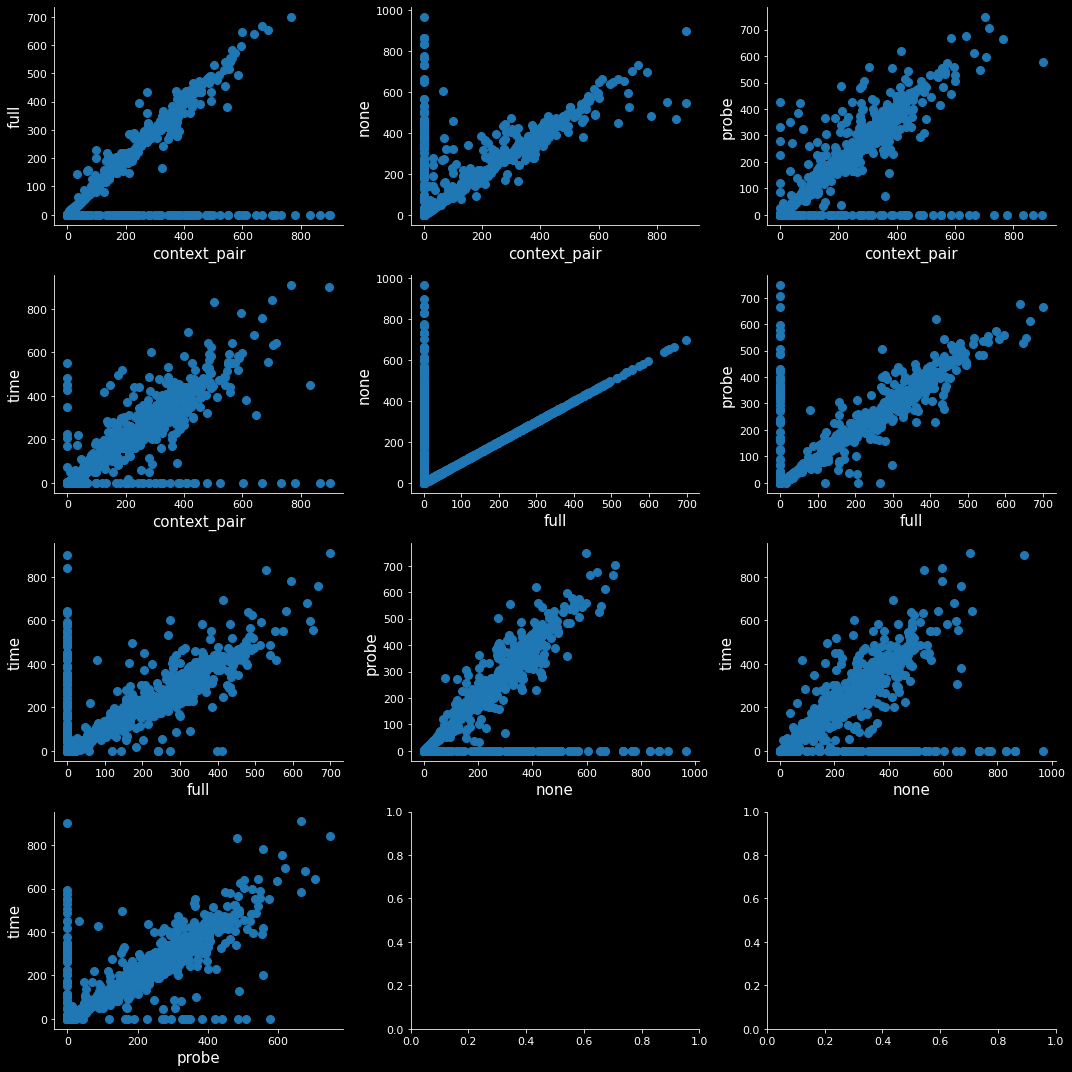

In [37]:
fig, axes = plt.subplots(4, 3, figsize=(15,15))
axes = np.ravel(axes)
for ii, (X, Y) in enumerate(itt.combinations(pivoted.columns, 2)):
    ax = axes[ii]

    ax.scatter(pivoted[X], pivoted[Y])
    ax.set_xlabel(X)
    ax.set_ylabel(Y)

this plot is lame. besides the dispersion in the unit line, the more astringent multiple comparisons lead to a bunch of
zero values